<a href="https://colab.research.google.com/github/YashsTiwari/Used-Car-Price-Prediction/blob/main/Used_Car_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Price Prediction 🚙 | Multiple Regression Models 📊

 - The **goal** is to predict the price of used cars based on various attributes.



In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00


In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re # from regex pattern (for extracting features)
from datetime import datetime # for deriving car's age
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold, cross_val_predict
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet
from scipy.stats import uniform
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor


In [3]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

In [4]:
df_train.head(3)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900


In [5]:
df_test.head(3)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN


In [6]:
# dropping id column
df_train=df_train.drop('id',axis=1)
df_test=df_test.drop('id',axis=1)

In [7]:
df_train.shape, df_test.shape

((188533, 12), (125690, 11))

### Checking missing values

In [8]:
missing_train = df_train.isna().mean() * 100
missing_test = df_test.isna().mean() * 100

print("Columns with missing values in df_train:")
print(missing_train[missing_train > 0])

print("\nColumns with missing values in df_test:")
print(missing_test[missing_test > 0])

Columns with missing values in df_train:
fuel_type       2.696080
accident        1.300568
clean_title    11.360876
dtype: float64

Columns with missing values in df_test:
fuel_type       2.691543
accident        1.298433
clean_title    11.328666
dtype: float64


In [9]:
print('for training data---\n')
for i in ['fuel_type','accident','clean_title']:
    print(f"{i}: {df_train[i].unique()}")

print('\nfor test data---\n')
for i in ['fuel_type','accident','clean_title']:
    print(f"{i}: {df_test[i].unique()}")

for training data---

fuel_type: ['Gasoline' 'E85 Flex Fuel' nan 'Hybrid' 'Diesel' 'Plug-In Hybrid' '–'
 'not supported']
accident: ['None reported' 'At least 1 accident or damage reported' nan]
clean_title: ['Yes' nan]

for test data---

fuel_type: ['Gasoline' 'Hybrid' 'Diesel' 'E85 Flex Fuel' nan 'Plug-In Hybrid' '–'
 'not supported']
accident: ['None reported' 'At least 1 accident or damage reported' nan]
clean_title: ['Yes' nan]


### imputing missing values using KNN imputer

In [10]:
from sklearn.impute import KNNImputer

def knn_impute(df, n_neighbors=5):
    df_encoded = df.copy()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
    knn_imputer = KNNImputer(missing_values=np.nan, n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)
    for col in df.select_dtypes(include='object').columns:
        df_imputed[col] = df_imputed[col].round().astype(int).map(
            dict(enumerate(df[col].astype('category').cat.categories)))
    return df_imputed

In [11]:
print("Missing values before imputation:")
print(df_train.isna().sum())

print("Missing values after imputation:")
df_train_imputed = knn_impute(df_train, n_neighbors=25)
print(df_train_imputed.isna().sum())


Missing values before imputation:
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64
Missing values after imputation:
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64


##### KNN imputer didn't work, doing manually

##### imputing fuel_type

In [12]:
df_train['fuel_type'].fillna('Electricity',inplace=True)
df_test['fuel_type'].fillna('Electricity',inplace=True)

<ipython-input-12-0d36e4d39a6f>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['fuel_type'].fillna('Electricity',inplace=True)
<ipython-input-12-0d36e4d39a6f>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

<ipython-input-13-dc5e86a828fc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_train['fuel_type'].value_counts().values,
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 li

Text(0, 0.5, 'Fuel Type')

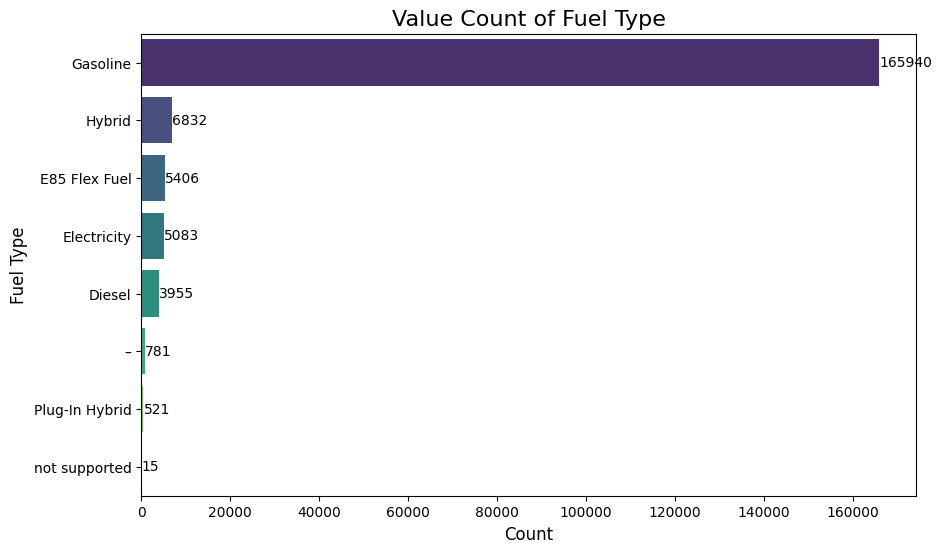

In [13]:
plt.figure(figsize=(10, 6))

# Create horizontal bar chart
sns.barplot(x=df_train['fuel_type'].value_counts().values,
            y=df_train['fuel_type'].value_counts().index,
            palette="viridis")

# Add labels for each bar
for index, value in enumerate(df_train['fuel_type'].value_counts().values):
    plt.text(value, index, f'{value}', va='center', fontsize=10)

# Titles and labels
plt.title('Value Count of Fuel Type', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Fuel Type', fontsize=12)

'not supported' and '-' types need to be handled (leaving it for now)

##### imputing clean_title

In [14]:
df_train['clean_title'].unique()

array(['Yes', nan], dtype=object)

In [15]:
df_train['clean_title'].fillna('No',inplace=True)
df_test['clean_title'].fillna('No',inplace=True)

<ipython-input-15-ede31cc241a5>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['clean_title'].fillna('No',inplace=True)
<ipython-input-15-ede31cc241a5>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

<ipython-input-16-66e48a0a99ca>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_train['clean_title'].value_counts().values,
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0, 0.5, 'Clean Title')

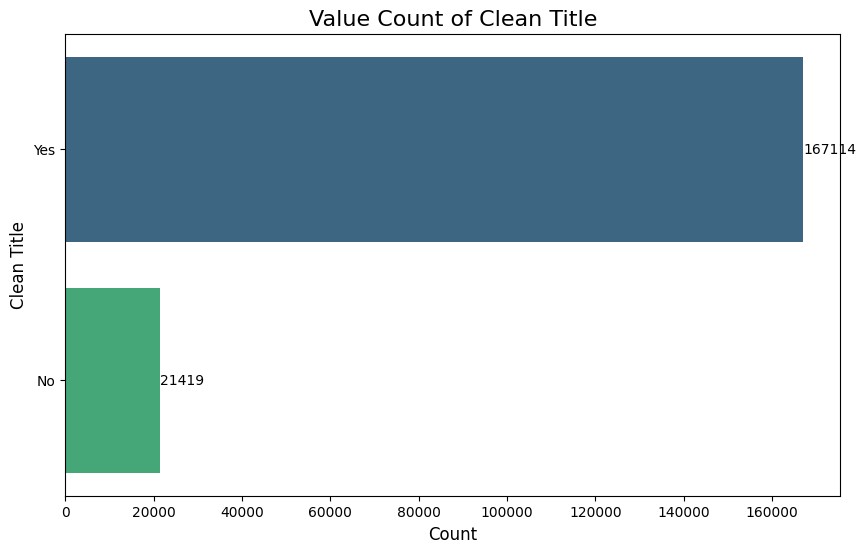

In [16]:
plt.figure(figsize=(10, 6))

# Create horizontal bar chart
sns.barplot(x=df_train['clean_title'].value_counts().values,
            y=df_train['clean_title'].value_counts().index,
            palette="viridis")

# Add labels for each bar
for index, value in enumerate(df_train['clean_title'].value_counts().values):
    plt.text(value, index, f'{value}', va='center', fontsize=10)

# Titles and labels
plt.title('Value Count of Clean Title', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Clean Title', fontsize=12)

##### imputing accident feature

In [17]:
df_train['accident'].unique()

array(['None reported', 'At least 1 accident or damage reported', nan],
      dtype=object)

In [18]:
# using mode
df_train['accident'].fillna('None reported',inplace=True)
df_test['accident'].fillna('None reported',inplace=True)

<ipython-input-18-b1fe71726ff4>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['accident'].fillna('None reported',inplace=True)
<ipython-input-18-b1fe71726ff4>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

<ipython-input-19-7ae158c44489>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_train['accident'].value_counts().values,
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0, 0.5, 'Accident')

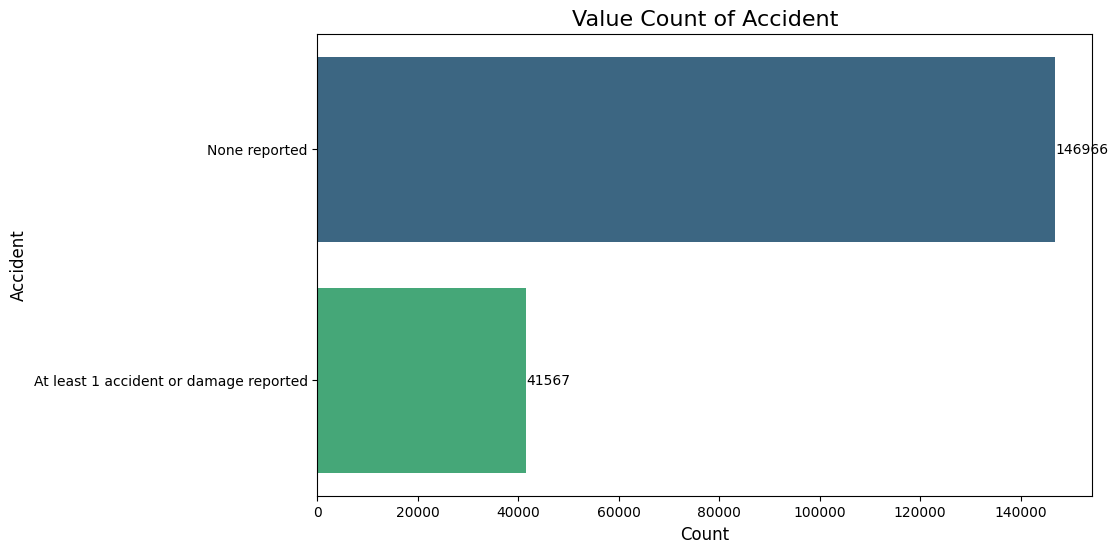

In [19]:
plt.figure(figsize=(10, 6))

# Create horizontal bar chart
sns.barplot(x=df_train['accident'].value_counts().values,
            y=df_train['accident'].value_counts().index,
            palette="viridis")

# Add labels for each bar
for index, value in enumerate(df_train['accident'].value_counts().values):
    plt.text(value, index, f'{value}', va='center', fontsize=10)

# Titles and labels
plt.title('Value Count of Accident', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Accident', fontsize=12)

In [20]:
missing_train = df_train.isna().mean() * 100
missing_test = df_test.isna().mean() * 100

print("Columns with missing values in df_train:")
print(missing_train[missing_train > 0])

print("\nColumns with missing values in df_test:")
print(missing_test[missing_test > 0])

Columns with missing values in df_train:
Series([], dtype: float64)

Columns with missing values in df_test:
Series([], dtype: float64)


### Extracing features

In [21]:
df_train.head(3)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900


Observation- enigne feature contains clubbed information, extracting new features from it

In [22]:
def extract_engine_features(df):
    # Use regex to extract HP, engine size (L or liter), and cylinders
    df['Horsepower'] = df['engine'].str.extract(r'(\d+\.\d*|\d+)HP', expand=False).astype(float)

    # Match engine size represented as either 'L' or 'liter' or 'Liter'
    df['Liters_engine'] = df['engine'].str.extract(r'(\d+\.\d*|\d+)\s*(?:L|liter|Liter)', expand=False).astype(float)

    df['Cylinders_count'] = df['engine'].str.extract(r'(\d+)\s+Cylinder', expand=False).astype(float)
    return df

df_train=extract_engine_features(df_train)
df_test=extract_engine_features(df_test)

In [23]:
df_train.head(3)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Liters_engine,Cylinders_count
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6,4.0
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,8.0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,8.0


In [24]:
# deriving car's age from model_year
def model_age(df):
    current_year=datetime.now().year
    df['model_age']=current_year-df['model_year']
    return df

df_train=model_age(df_train)
df_test=model_age(df_test)

In [25]:
# dropping useless features
df_train.drop(['model_year','engine'],axis=1,inplace=True)
df_test.drop(['model_year','engine'],axis=1,inplace=True)

Observation- model needs to be handled properly as it contains high no. of unique values (this is will handled later)

In [26]:
# checking nan values for new extracted or derived features
missing_train = df_train.isna().mean() * 100
missing_test = df_test.isna().mean() * 100

print("Columns with missing values in df_train:")
print(missing_train[missing_train > 0])

print("\nColumns with missing values in df_test:")
print(missing_test[missing_test > 0])

Columns with missing values in df_train:
Horsepower         17.640943
Liters_engine       3.552694
Cylinders_count    20.078713
dtype: float64

Columns with missing values in df_test:
Horsepower         17.647386
Liters_engine       3.484764
Cylinders_count    20.009547
dtype: float64


In [27]:
df_train['Cylinders_count'].nunique()

7

In [28]:
df_train['Horsepower'].nunique()

348

In [29]:
df_train['Liters_engine'].nunique()

61

#### Using imputers for handling missing values (for newly extracted features)

In [30]:
imputer=IterativeImputer(max_iter=10, tol=1e-3, random_state=0)
df_train[['Horsepower', 'Liters_engine']] = imputer.fit_transform(df_train[['Horsepower', 'Liters_engine']])
df_test[['Horsepower', 'Liters_engine']] = imputer.transform(df_test[['Horsepower', 'Liters_engine']])

# Simple Imputer for less complex columns
simple_imputer = SimpleImputer(strategy='mean')
df_train['Cylinders_count'] = simple_imputer.fit_transform(df_train[['Cylinders_count']])
df_test['Cylinders_count'] = simple_imputer.transform(df_test[['Cylinders_count']])

In [31]:
missing_train1 = df_train.isna().mean() * 100
missing_test1 = df_test.isna().mean() * 100

print("Columns in df_train")
print(missing_train1[missing_train1 > 0])

print("\nColumns in df_test")
print(missing_test1[missing_test1 > 0])

Columns in df_train
Series([], dtype: float64)

Columns in df_test
Series([], dtype: float64)


#### ----------------------------------------> Missing values settled <----------------------------------------

In [32]:
df_train.head()

,brand,model,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Liters_engine,Cylinders_count,model_age
0,MINI,Cooper S Base,213000,Gasoline,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6,4.0,17
1,Lincoln,LS V8,143250,Gasoline,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,8.0,22
2,Chevrolet,Silverado 2500 LT,136731,E85 Flex Fuel,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,8.0,22
3,Genesis,G90 5.0 Ultimate,19500,Gasoline,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0,5.0,8.0,7
4,Mercedes-Benz,Metris Base,7388,Gasoline,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0,2.0,4.0,3


In [33]:
df_train['transmission'].nunique()

52

In [34]:
df_train['transmission'].unique()

array(['A/T', 'Transmission w/Dual Shift Mode', '7-Speed A/T',
       '8-Speed A/T', '10-Speed Automatic', '1-Speed A/T', '6-Speed A/T',
       '10-Speed A/T', '9-Speed A/T', '8-Speed Automatic',
       '9-Speed Automatic', '5-Speed A/T', 'Automatic',
       '7-Speed Automatic with Auto-Shift', 'CVT Transmission',
       '5-Speed M/T', 'M/T', '6-Speed M/T', '6-Speed Automatic',
       '4-Speed Automatic', '7-Speed M/T', '2-Speed A/T',
       '1-Speed Automatic', 'Automatic CVT', '4-Speed A/T',
       '6-Speed Manual', 'Transmission Overdrive Switch',
       '8-Speed Automatic with Auto-Shift', '7-Speed Manual',
       '7-Speed Automatic', '9-Speed Automatic with Auto-Shift',
       '6-Speed Automatic with Auto-Shift',
       '6-Speed Electronically Controlled Automatic with O', 'F', 'CVT-F',
       '8-Speed Manual', 'Manual', '–', '2', '6 Speed At/Mt',
       '5-Speed Automatic', '2-Speed Automatic', '8-SPEED A/T', '7-Speed',
       'Variable', 'Single-Speed Fixed Gear', '8-SPEED AT',


#### Grouping and encoding transmission values

In [35]:

def transmission_category(transmission):
    transmission = transmission.strip().lower()  # Convert to lowercase for easier matching
    if any(keyword in transmission for keyword in ['automatic', 'a/t']):
        return 1
    elif any(keyword in transmission for keyword in ['manual', 'm/t']):
        return 2
    elif any(keyword in transmission for keyword in ['cvt']):
        return 3
    else:
        return 4

df_train['transmission']=df_train['transmission'].apply(transmission_category)
df_test['transmission']=df_test['transmission'].apply(transmission_category)

print(df_train['transmission'].value_counts())
print('='*20)
print(df_test['transmission'].value_counts())

transmission
1    150302
4     19868
2     16358
3      2005
Name: count, dtype: int64
transmission
1    100296
4     13260
2     10785
3      1349
Name: count, dtype: int64


#### Encoding Accident and Clean Title

In [36]:
df_train['accident'].unique(),df_train['clean_title'].unique()

(array(['None reported', 'At least 1 accident or damage reported'],
       dtype=object),
 array(['Yes', 'No'], dtype=object))

In [37]:
def mapping_columns(df):
    df['accident']=df['accident'].replace({
        'At least 1 accident or damage reported': 1,
        'None reported': 0
    })
    df["clean_title"] = df["clean_title"].replace({
        "Yes": 1,
        "No": 0
    })
    return df

In [38]:
df_train = mapping_columns(df_train)
df_test = mapping_columns(df_test)

<ipython-input-37-97d22dbfc601>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['accident']=df['accident'].replace({
<ipython-input-37-97d22dbfc601>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["clean_title"] = df["clean_title"].replace({


In [39]:
df_train.head()

,brand,model,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Liters_engine,Cylinders_count,model_age
0,MINI,Cooper S Base,213000,Gasoline,1,Yellow,Gray,0,1,4200,172.0,1.6,4.0,17
1,Lincoln,LS V8,143250,Gasoline,1,Silver,Beige,1,1,4999,252.0,3.9,8.0,22
2,Chevrolet,Silverado 2500 LT,136731,E85 Flex Fuel,1,Blue,Gray,0,1,13900,320.0,5.3,8.0,22
3,Genesis,G90 5.0 Ultimate,19500,Gasoline,4,Black,Black,0,1,45000,420.0,5.0,8.0,7
4,Mercedes-Benz,Metris Base,7388,Gasoline,1,Black,Beige,0,1,97500,208.0,2.0,4.0,3


In [40]:
df_train['fuel_type'].nunique(),df_train['ext_col'].nunique(),df_train['int_col'].nunique(),df_train['model'].nunique()

(8, 319, 156, 1897)

using 2 approaches-
- dropping model feature

In [41]:
df_train_with_model=df_train.copy()
df_test_with_model=df_test.copy()

df_train.drop('model',axis=1,inplace=True)
df_test.drop('model',axis=1,inplace=True)

In [42]:
df_train.head(3)

,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Liters_engine,Cylinders_count,model_age
0,MINI,213000,Gasoline,1,Yellow,Gray,0,1,4200,172.0,1.6,4.0,17
1,Lincoln,143250,Gasoline,1,Silver,Beige,1,1,4999,252.0,3.9,8.0,22
2,Chevrolet,136731,E85 Flex Fuel,1,Blue,Gray,0,1,13900,320.0,5.3,8.0,22


using label encoder for brand, fuel_type,ext_col,int_col (other approach can also be considered)

In [43]:
cat_col=['brand','fuel_type','int_col','ext_col']
lb=LabelEncoder()

for col in cat_col:
  df_train[col]=lb.fit_transform(df_train[col])
  df_test[col]=lb.transform(df_test[col])

In [44]:
df_train.head()

,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Liters_engine,Cylinders_count,model_age
0,31,213000,3,1,312,71,0,1,4200,172.0,1.6,4.0,17
1,28,143250,3,1,263,10,1,1,4999,252.0,3.9,8.0,22
2,9,136731,1,1,38,71,0,1,13900,320.0,5.3,8.0,22
3,16,19500,3,4,29,14,0,1,45000,420.0,5.0,8.0,7
4,36,7388,3,1,29,10,0,1,97500,208.0,2.0,4.0,3


In [45]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   brand            188533 non-null  int64  
 1   milage           188533 non-null  int64  
 2   fuel_type        188533 non-null  int64  
 3   transmission     188533 non-null  int64  
 4   ext_col          188533 non-null  int64  
 5   int_col          188533 non-null  int64  
 6   accident         188533 non-null  int64  
 7   clean_title      188533 non-null  int64  
 8   price            188533 non-null  int64  
 9   Horsepower       188533 non-null  float64
 10  Liters_engine    188533 non-null  float64
 11  Cylinders_count  188533 non-null  float64
 12  model_age        188533 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 18.7 MB


--------------> all features are now numeric

### Correlation Matrix

Text(0.5, 1.0, 'Correlation Heatmap')

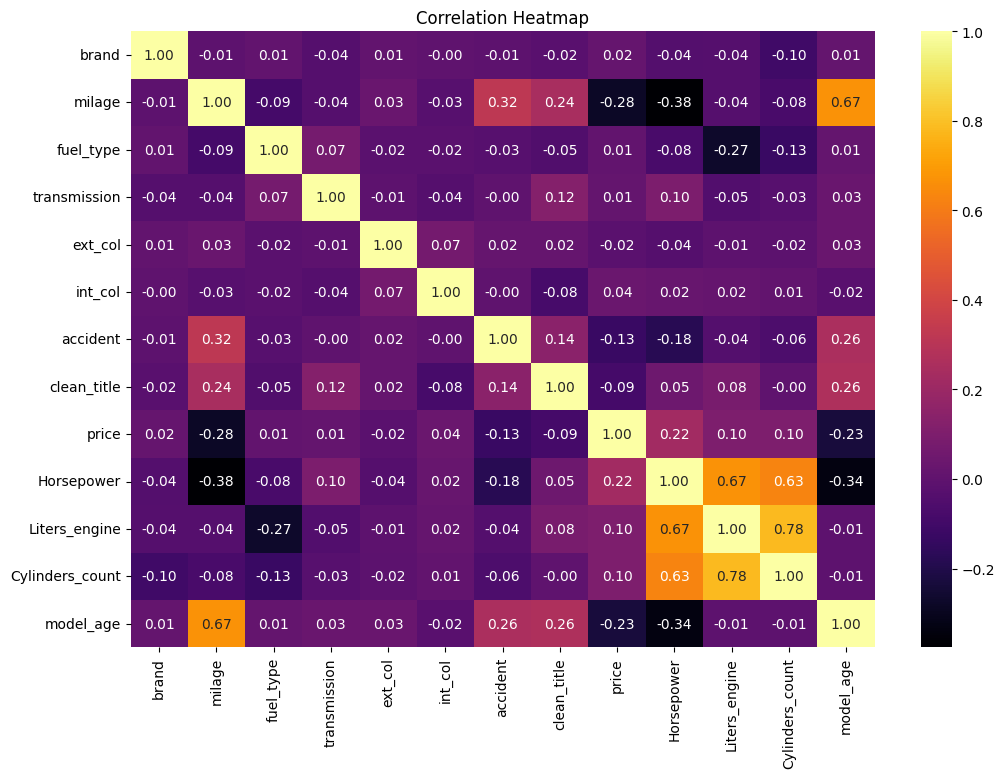

In [46]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_train.corr(),annot=True,cmap='inferno',fmt='.2f')
plt.title('Correlation Heatmap')

Observations -
- Some value pairs like *horsepower : cylinders_count*, *liter_engine : cylinders_count*, *model_age : milage*, *horsepower : liter_engine* are fairly correlated **BUT** since the correlation is not very high so we're leaving it as it is.

- We can also consider trying finding relation b/w them and can try dropping or merging features in later stages. (optional, will more depend on model performance)



### Checking Distribution of Price (Target variable)

Text(0.5, 0, 'Price')

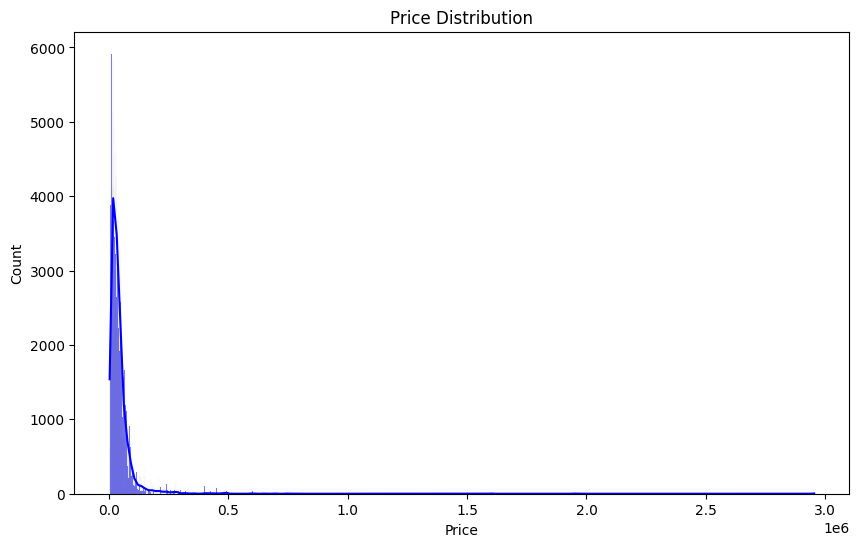

In [47]:
plt.figure(figsize=(10,6))
sns.histplot(df_train['price'], kde=True, color='blue')
plt.title('Price Distribution')
plt.xlabel('Price')

#### Applying log transformation to transform the price feature

In [48]:
df_train['price']=np.log1p(df_train['price'])

Text(0.5, 0, 'Price')

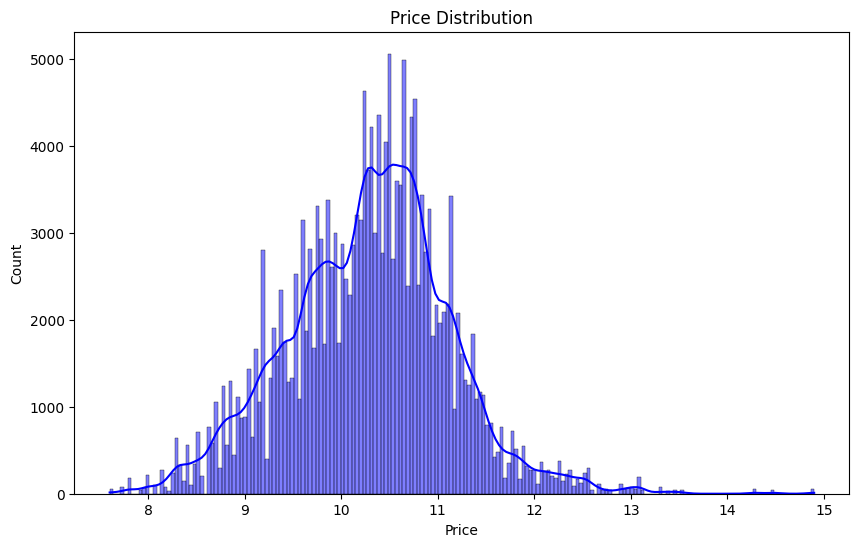

In [49]:
plt.figure(figsize=(10,6))
sns.histplot(df_train['price'],kde=True,color='blue')
plt.title('Price Distribution')
plt.xlabel('Price')

In [50]:
df_train.head()

,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Liters_engine,Cylinders_count,model_age
0,31,213000,3,1,312,71,0,1,8.343078,172.0,1.6,4.0,17
1,28,143250,3,1,263,10,1,1,8.517193,252.0,3.9,8.0,22
2,9,136731,1,1,38,71,0,1,9.539716,320.0,5.3,8.0,22
3,16,19500,3,4,29,14,0,1,10.714440,420.0,5.0,8.0,7
4,36,7388,3,1,29,10,0,1,11.487618,208.0,2.0,4.0,3


In [51]:
df_test.head()

,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,Horsepower,Liters_engine,Cylinders_count,model_age
0,26,98000,3,1,304,10,0,1,240.000000,2.0,4.000000,9
1,26,9142,4,1,263,14,0,1,395.000000,3.0,6.000000,4
2,14,28121,3,1,304,57,0,0,324.098554,3.5,6.374268,2
3,3,61258,3,1,261,14,0,0,244.550292,2.0,6.374268,8
4,3,59000,3,1,128,14,0,1,252.000000,2.0,4.000000,6


### Scaling continuous features

In [52]:
scaler=StandardScaler()
continuous_features=['milage','Horsepower','Liters_engine','Cylinders_count','model_age']
df_train[continuous_features]=scaler.fit_transform(df_train[continuous_features])
df_test[continuous_features]=scaler.transform(df_test[continuous_features])

In [53]:
df_train.head()

,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Horsepower,Liters_engine,Cylinders_count,model_age
0,31,2.957842,3,1,312,71,0,1,8.343078,-1.560199,-1.619039,-1.708391,1.559808
1,28,1.557184,3,1,263,10,1,1,8.517193,-0.820242,0.063903,1.169786,2.443052
2,9,1.426276,1,1,38,71,0,1,9.539716,-0.191278,1.088303,1.169786,2.443052
3,16,-0.927854,3,4,29,14,0,1,10.714440,0.733668,0.868789,1.169786,-0.206679
4,36,-1.171076,3,1,29,10,0,1,11.487618,-1.227218,-1.326354,-1.708391,-0.913274


In [54]:
df_test.head()

,brand,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,Horsepower,Liters_engine,Cylinders_count,model_age
0,26,0.648514,3,1,304,10,0,1,-0.931235,-1.326354,-1.708391,0.146618
1,26,-1.135854,4,1,263,14,0,1,0.502432,-0.594640,-0.269303,-0.736626
2,14,-0.754735,3,1,304,57,0,0,-0.153369,-0.228782,0.000000,-1.089923
3,3,-0.089307,3,1,261,14,0,0,-0.889148,-1.326354,0.000000,-0.030031
4,3,-0.134650,3,1,128,14,0,1,-0.820242,-1.326354,-1.708391,-0.383328


In [55]:
X=df_train.drop('price',axis=1)
y=df_train['price']
X.shape,y.shape

((188533, 12), (188533,))

In [56]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Setting up Dask (Not using it)

In [ ]:
pip install dask-ml "dask[complete]"

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 16.9 MB/s eta 0:00:00


In [ ]:
from dask.distributed import Client

# Set up a Dask client to manage your workers
client = Client()  # This uses your local machine's cores
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:40629
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35863'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43843'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:34323', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:34323
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:46114
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:45479', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker co

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 12.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40629,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 12.67 GiB
Comm: tcp://127.0.0.1:45479,Total threads: 1
Dashboard: http://127.0.0.1:36397/status,Memory: 6.34 GiB
Nanny: tcp://127.0.0.1:35863,


In [ ]:
import dask.dataframe as dd

# Assuming your data is in Pandas DataFrames
X_train_dask = dd.from_pandas(X_train, npartitions=10)  # Adjust npartitions based on your system
y_train_dask = dd.from_pandas(y_train, npartitions=10)

In [ ]:
from dask_ml.model_selection import RandomizedSearchCV

In [ ]:
# Create Dask DataFrames
X_train_dask = dd.from_pandas(X_train, npartitions=10)
y_train_dask = dd.from_pandas(y_train, npartitions=10)

## Model training with hyperparameter tuning

### Baseline models

- Using Mean as a Model

In [ ]:
from sklearn.dummy import DummyRegressor
from dask_ml.wrappers import ParallelPostFit

# Initialize the Dummy Regressor with strategy 'mean'
dummy_model = DummyRegressor(strategy='mean')

# Use ParallelPostFit to allow fitting on Dask
parallel_dummy = ParallelPostFit(estimator=dummy_model)

# Fit the baseline model on the Dask DataFrames
parallel_dummy.fit(X_train_dask, y_train_dask)

# Optionally convert X_val to Dask DataFrame for prediction
X_val_dask = dd.from_pandas(X_val, npartitions=10)  # Assuming X_val is your validation features

# Predict on the validation set
y_pred_dummy_dask = parallel_dummy.predict(X_val_dask)

# Convert back to Pandas for RMSE calculation
y_pred_dummy = y_pred_dummy_dask.compute()

rmse_dummy = np.sqrt(np.mean((np.expm1(y_pred_dummy) - np.expm1(y_val))**2))

print(f'Baseline Model (Mean) RMSE: {rmse_dummy:.2f}')

Baseline Model (Mean) RMSE: 75940.34


- Using Linear Regression

In [68]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_val)

y_train_pred_lr = model_lr.predict(X_train)
train_rmse_lr = np.sqrt(np.mean((np.expm1(y_train_pred_lr) - np.expm1(y_train)) ** 2))

# Predict on validation data to calculate Validation RMSE
y_val_pred_lr = model_lr.predict(X_val)
val_rmse_lr = np.sqrt(np.mean((np.expm1(y_val_pred_lr) - np.expm1(y_val)) ** 2))

# Calculate R-squared on validation data
r2_lgb = r2_score(y_val, y_val_pred_lr)
r2_percentage_lr = r2_lgb * 100  # Convert to percentage

# Print RMSE and R-squared results
print(f'Training RMSE: {train_rmse_lr:.2f}')
print(f'Validation RMSE: {val_rmse_lr:.2f}')
print(f'R-squared: {r2_percentage_lr:.2f}%')

Training RMSE: 76191.34
Validation RMSE: 70546.77
R-squared: 59.87%


##### Base model best RMSE (Linear regression)= 70546.77

### Decision Tree Hyper parameter tuning (with clipped data)

In [ ]:

# Hyperparameter distribution
param_dist_dt = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error']
}

# Initialize the model
decision_tree = DecisionTreeRegressor(random_state=42)

# Random search over the parameter grid
random_search_dt = RandomizedSearchCV(
    estimator=decision_tree,
    param_distributions=param_dist_dt,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    verbose=2,
)

# Fit the model using the sample data
random_search_dt.fit(X_train[:50000], y_train[:50000])
best_params_dt = random_search_dt.best_params_
print("Best Parameters for Decision Tree:", best_params_dt)

# Predict on the validation set
y_pred = random_search_dt.predict(X_val)

# Evaluate the model (assuming target is log-transformed)
rmse = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))

print(f'Optimized Decision Tree RMSE: {rmse:.2f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END criterion=squared_error, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5; total time=   0.1s
[CV] END criterion=squared_error, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5; total time=   0.1s
[CV] END criterion=squared_error, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5; total time=   0.1s
[CV] END criterion=squared_error, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5; total time=   0.1s
[CV] END criterion=squared_error, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.3s
[CV] END criterion=friedman_mse, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.3s
[CV] END criterion=friedman_mse, max_depth=20, ma

Observations -

- Best Parameters for Decision Tree: {'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 5, 'criterion': 'squared_error'}
Optimized Decision Tree RMSE: 70334.09 ----> 10k rows

- Best Parameters for Decision Tree: {'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 5, 'criterion': 'absolute_error'}
Optimized Decision Tree RMSE: 70485.53 ----> 20K rows

- Best Parameters for Decision Tree: {'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 5, 'criterion': 'squared_error'}
Optimized Decision Tree RMSE: 70199.46 ----> 30k rows

- Best Parameters for Decision Tree: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 10, 'criterion': 'absolute_error'}
Optimized Decision Tree RMSE: 69882.79 ----> 50k rows

### **Final Best Parameters for Decision Tree**===> {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 10, 'criterion': 'absolute_error'}

----------------------------------------------> Training DT with 100% data with these params <---------------------------------------------

In [66]:
# Initialize the model with best params directly
decision_tree = DecisionTreeRegressor(
    random_state=42,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features=None,
    max_depth=10,
    criterion='absolute_error'
)

# Fit the model using 100% of the training data
decision_tree.fit(X_train, y_train)

y_train_pred = decision_tree.predict(X_train)
# Calculate RMSE for training data using your formula
train_rmse = np.sqrt(np.mean((np.expm1(y_train_pred) - np.expm1(y_train)) ** 2))

# Predict on validation data
y_val_pred = decision_tree.predict(X_val)
# Calculate RMSE for validation data using your formula
val_rmse = np.sqrt(np.mean((np.expm1(y_val_pred) - np.expm1(y_val)) ** 2))

r2 = r2_score(y_val, y_val_pred)
r2_percentage = r2 * 100  # Convert to percentage

# Print RMSE results
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Validation RMSE: {val_rmse:.2f}')
print(f'R-squared: {r2_percentage:.2f}%')


Training RMSE: 75105.33
Validation RMSE: 69624.15
R-squared: 63.34%


Observations -

- Training RMSE: 75105.33
- Validation RMSE: 69624.15
- R-squared: 63.34%

### Decision Tree using Dask (Not using)

In [ ]:
# Define the DecisionTree model
decision_tree = DecisionTreeRegressor(random_state=42)

# Define the parameter distribution for Randomized Search
param_dist_dt = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
}

# Use RandomizedSearchCV to search over parameters with Dask
random_search_dt = RandomizedSearchCV(
    estimator=decision_tree,
    param_distributions=param_dist_dt,
    n_iter=5,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the model on Dask DataFrames
random_search_dt.fit(X_train_dask, y_train_dask)

# Get the best parameters
best_params_dt = random_search_dt.best_params_
print("Best Parameters for Decision Tree:", best_params_dt)

# Optionally convert X_val to Dask DataFrame for prediction
X_val_dask = dd.from_pandas(X_val, npartitions=10)

# Predict on the validation set with the best model
y_pred_dask = random_search_dt.predict(X_val_dask)

# Since y_pred_dask is already a NumPy array, you can use it directly for RMSE calculation
rmse = np.sqrt(np.mean((np.expm1(y_pred_dask) - np.expm1(y_val))**2))

print(f'Optimized Decision Tree RMSE: {rmse:.2f}')


Streaming output truncated to the last 5000 lines.
INFO:distributed.scheduler:Client Client-b765dce5-817c-11ef-80da-0242ac1c000c requests to retry 1 keys
INFO:distributed.scheduler:Client Client-b765dce5-817c-11ef-80da-0242ac1c000c requests to retry 1 keys
INFO:distributed.scheduler:Client Client-b765dce5-817c-11ef-80da-0242ac1c000c requests to retry 1 keys
INFO:distributed.scheduler:Client Client-b765dce5-817c-11ef-80da-0242ac1c000c requests to retry 1 keys
INFO:distributed.scheduler:Client Client-b765dce5-817c-11ef-80da-0242ac1c000c requests to retry 1 keys
INFO:distributed.scheduler:Client Client-b765dce5-817c-11ef-80da-0242ac1c000c requests to retry 1 keys
INFO:distributed.scheduler:Client Client-b765dce5-817c-11ef-80da-0242ac1c000c requests to retry 1 keys
INFO:distributed.scheduler:Client Client-b765dce5-817c-11ef-80da-0242ac1c000c requests to retry 1 keys
INFO:distributed.scheduler:Client Client-b765dce5-817c-11ef-80da-0242ac1c000c requests to retry 1 keys
INFO:distributed.sched

### Random Forest Regression Hyper parameter tuning (with clipped data)

In [ ]:
param_dist_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_features': [None, 'sqrt', 'log2'],  # Number of features to consider for the best split
    'max_depth': [None, 5, 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}
# {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}
# Optimized Random Forest RMSE: 69412.05

# Initialize the model
random_forest = RandomForestRegressor(random_state=42)

# Random search over the parameter grid
random_search_rf = RandomizedSearchCV(
    estimator=random_forest,
    param_distributions=param_dist_rf,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    verbose=2
)
random_search_rf.fit(X_train[:50000], y_train[:50000])

# Get the best parameters
best_params_rf = random_search_rf.best_params_
print("Best Parameters for Random Forest:", best_params_rf)

# Predict on the validation set with the best model
y_pred_rf = random_search_rf.predict(X_val)

# Evaluate the model
rmse_rf = np.sqrt(np.mean((np.expm1(y_pred_rf) - np.expm1(y_val))**2))

print(f'Optimized Random Forest RMSE: {rmse_rf:.2f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total ti

Observations -

- Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}
Optimized Random Forest RMSE: 69614.16 ----> 10k

- Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}
Optimized Random Forest RMSE: 69391.56 -----> 20k

- Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}
Optimized Random Forest RMSE: 69223.35 -----> 30k

- Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}
Optimized Random Forest RMSE: 69114.90 -----> 50k

### **Final Best Parameters for Random Forest** ===> {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}

----------------------------------------------> Training RF with 100% data with these params <---------------------------------------------

In [58]:
rf= RandomForestRegressor(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    max_depth=20)
# Fit the model using 100% of the training data
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
# Calculate RMSE for training data using your formula
train_rmse = np.sqrt(np.mean((np.expm1(y_train_pred) - np.expm1(y_train)) ** 2))

# Predict on validation data
y_val_pred = rf.predict(X_val)
# Calculate RMSE for validation data using your formula
val_rmse = np.sqrt(np.mean((np.expm1(y_val_pred) - np.expm1(y_val)) ** 2))

r2 = r2_score(y_val, y_val_pred)
r2_percentage = r2 * 100  # Convert to percentage

# Print RMSE results
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Validation RMSE: {val_rmse:.2f}')
print(f'R-squared: {r2_percentage:.2f}%')


Training RMSE: 72490.53
Validation RMSE: 68823.68
R-squared: 65.86%


Observations -

- Training RMSE: 72495.67
- Validation RMSE: 68814.84
- R-squared: 65.86%

### AdaBoost Regression Hyper parameter tuning (with clipped data)

In [ ]:
# Hyperparameter distribution for AdaBoost
param_dist_ada = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'estimator__max_depth': [3, 5, 7],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 5],
    'loss': ['linear', 'square', 'exponential'],
}

# Initialize the base estimator (DecisionTreeRegressor for AdaBoost)
base_estimator = DecisionTreeRegressor(random_state=42)

# Initialize the AdaBoostRegressor
ada_boost = AdaBoostRegressor(estimator=base_estimator, random_state=42)

# Random search over the parameter grid
random_search_ada = RandomizedSearchCV(
    estimator=ada_boost,
    param_distributions=param_dist_ada,
    n_iter=20,  # Number of iterations
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    verbose=2,
)

# Fit the model using a subset of the training data
random_search_ada.fit(X_train[:50000], y_train[:50000])

# Get the best parameters
best_params_ada = random_search_ada.best_params_
print("Best Parameters for AdaBoost:", best_params_ada)

# Predict on the validation set
y_pred_ada = random_search_ada.predict(X_val)

# Evaluate the model using your RMSE formula
rmse_ab = np.sqrt(np.mean((np.expm1(y_pred) - np.expm1(y_val)) ** 2))

print(f'Optimized AdaBoost RMSE: {rmse_ab:.2f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END estimator__max_depth=5, estimator__min_samples_leaf=2, estimator__min_samples_split=2, learning_rate=0.1, loss=exponential, n_estimators=200; total time=  18.1s
[CV] END estimator__max_depth=5, estimator__min_samples_leaf=2, estimator__min_samples_split=2, learning_rate=0.1, loss=exponential, n_estimators=200; total time=  17.8s
[CV] END estimator__max_depth=5, estimator__min_samples_leaf=2, estimator__min_samples_split=2, learning_rate=0.1, loss=exponential, n_estimators=200; total time=  17.7s
[CV] END estimator__max_depth=5, estimator__min_samples_leaf=2, estimator__min_samples_split=2, learning_rate=0.1, loss=exponential, n_estimators=200; total time=  18.6s
[CV] END estimator__max_depth=5, estimator__min_samples_leaf=2, estimator__min_samples_split=2, learning_rate=0.1, loss=exponential, n_estimators=200; total time=  18.6s
[CV] END estimator__max_depth=3, estimator__min_samples_leaf=5, estimator__min_samples_s

Observations -

- Best Parameters for AdaBoost: {'n_estimators': 50, 'loss': 'square', 'learning_rate': 0.01, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': 7}
Optimized AdaBoost RMSE: 68817.45 -----> 10k

- Best Parameters for AdaBoost: {'n_estimators': 50, 'loss': 'square', 'learning_rate': 0.01, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': 7}
Optimized AdaBoost RMSE: 68817.45 -----> 20k

- Best Parameters for AdaBoost: {'n_estimators': 50, 'loss': 'square', 'learning_rate': 0.01, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': 7}
Optimized AdaBoost RMSE: 68817.45 -----> 30k

- Best Parameters for AdaBoost: {'n_estimators': 50, 'loss': 'square', 'learning_rate': 0.01, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': 7}
Optimized AdaBoost RMSE: 68817.45 -----> 50k

### **Final Best Parameters for AdaBoost** ===> {'n_estimators': 50, 'loss': 'square', 'learning_rate': 0.01, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': 7}

----------------------------------------------> Training AB with 100% data with these params <---------------------------------------------

In [59]:
ab=AdaBoostRegressor(
    n_estimators=50,
    loss='square',
    learning_rate=0.01,
    estimator=DecisionTreeRegressor(max_depth=7, min_samples_leaf=1, min_samples_split=10),
)

ab.fit(X_train,y_train)

y_train_pred = ab.predict(X_train)
# Calculate RMSE for training data using your formula
train_rmse = np.sqrt(np.mean((np.expm1(y_train_pred) - np.expm1(y_train)) ** 2))

# Predict on validation data
y_val_pred = ab.predict(X_val)
# Calculate RMSE for validation data using your formula
val_rmse = np.sqrt(np.mean((np.expm1(y_val_pred) - np.expm1(y_val)) ** 2))

# Calculate R-squared for validation data
r2 = r2_score(y_val, y_val_pred)
r2_percentage = r2 * 100  # Convert to percentage

# Print RMSE results
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Validation RMSE: {val_rmse:.2f}')
print(f'R-squared: {r2_percentage:.2f}%')


Training RMSE: 74900.23
Validation RMSE: 74425.85
R-squared: 62.86%


Observations -

- Training RMSE: 75268.70
- Validation RMSE: 69649.08
- R-squared: 63.14%

### XGB Regression Hyper parameter tuning with clipped data

In [ ]:
param_grid_xgb = {
    'objective': ['reg:squarederror'],
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 0.1, 0.2]
}

xgb_model = XGBRegressor(verbose=0)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid_xgb,
    n_iter=20,  # Number of iterations
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit the model using a subset of the training data
random_search_xgb.fit(X_train[:50000], y_train[:50000])

# Get the best parameters
best_params_xgb = random_search_xgb.best_params_
print("Best Parameters for XGBoost:", best_params_xgb)

# Predict on the validation set
y_pred_xgb = random_search_xgb.predict(X_val)

# Evaluate the model using your RMSE formula
rmse_xgb = np.sqrt(np.mean((np.expm1(y_pred_xgb) - np.expm1(y_val)) ** 2))

print(f'Optimized XGBoost RMSE: {rmse_xgb:.2f}')

# Optionally, calculate R-squared
from sklearn.metrics import r2_score

r2_xgb = r2_score(y_val, y_pred_xgb)
print(f'R-squared: {r2_xgb * 100:.2f}%')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:00:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'subsample': 1.0, 'objective': 'reg:squarederror', 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
Optimized XGBoost RMSE: 68988.40
R-squared: 65.36%


Observations -

- Best Parameters for XGBoost: {'subsample': 1.0, 'objective': 'reg:squarederror', 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7} ----> 50k
- Optimized XGBoost RMSE: 68988.40
- R-squared: 65.36%

### **Final Best Parameters for XGB** ===> {'subsample': 1.0, 'objective': 'reg:squarederror', 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}

---------------------------------------------> Training XGB with 100% data with these params <--------------------------------------------

In [60]:
# Initialize the XGBoost model with best parameters found
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=3,
    subsample=1.0,
    colsample_bytree=0.7,
    gamma=0,
    objective='reg:squarederror'
)

# Fit the model using 100% of the training data
xgb.fit(X_train, y_train)

# Predict on training data
y_train_pred = xgb.predict(X_train)
# Calculate RMSE for training data using your formula
train_rmse = np.sqrt(np.mean((np.expm1(y_train_pred) - np.expm1(y_train)) ** 2))

# Predict on validation data
y_val_pred = xgb.predict(X_val)
# Calculate RMSE for validation data using your formula
val_rmse = np.sqrt(np.mean((np.expm1(y_val_pred) - np.expm1(y_val)) ** 2))

# Calculate R-squared
r2 = r2_score(y_val, y_val_pred)
r2_percentage = r2 * 100  # Convert to percentage

# Print RMSE results
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Validation RMSE: {val_rmse:.2f}')
print(f'R-squared: {r2_percentage:.2f}%')

Training RMSE: 74300.39
Validation RMSE: 68871.26
R-squared: 65.73%


Observations -

- Training RMSE: 74300.39
- Validation RMSE: 68871.26
- R-squared: 65.73%

### CatBoost Regression Hyper parameter tuning with clipped data

In [ ]:
# Define the parameter grid for CatBoost
param_dist_cat = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.5],
    'depth': [3, 5, 7, 10],
    'l2_leaf_reg': [1, 3, 5],
    'subsample': [0.5, 0.7, 1.0],
    'bagging_temperature': [0, 1, 2],
    'random_strength': [0, 1, 2],
}

# Initialize the CatBoostRegressor
catboost_model = CatBoostRegressor(silent=True, random_state=42)

# Random search over the parameter grid
random_search_cat = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist_cat,
    n_iter=20,  # Number of iterations
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit the model using a subset of the training data
random_search_cat.fit(X_train[:50000], y_train[:50000])

# Get the best parameters
best_params_cat = random_search_cat.best_params_
print("Best Parameters for CatBoost:", best_params_cat)

# Predict on the validation set using the best estimator
y_pred_cat = random_search_cat.predict(X_val)

# Evaluate the model using your RMSE formula
rmse_cat = np.sqrt(np.mean((np.expm1(y_pred_cat) - np.expm1(y_val)) ** 2))

# Calculate R-squared
r2_cat = r2_score(y_val, y_pred_cat)
r2_percentage_cat = r2_cat * 100  # Convert to percentage

# Print RMSE results
print(f'Optimized CatBoost RMSE: {rmse_cat:.2f}')
print(f'R-squared: {r2_percentage_cat:.2f}%')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters for CatBoost: {'subsample': 0.5, 'random_strength': 2, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 5, 'bagging_temperature': 2}
Optimized CatBoost RMSE: 69063.08
R-squared: 65.19%


Observations -

- Best Parameters for CatBoost: {'subsample': 0.5, 'random_strength': 2, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 5, 'bagging_temperature': 2}
- Optimized CatBoost RMSE: 69063.08
- R-squared: 65.19%

### **Final Best Parameters for CatBoost** ===> {'subsample': 0.5, 'random_strength': 2, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 5, 'bagging_temperature': 2}

---------------------------------------------> Training CB with 100% data with these params <--------------------------------------------

In [61]:
# Initialize CatBoostRegressor with the best hyperparameters
catboost_best = CatBoostRegressor(
    subsample=0.5,
    random_strength=2,
    learning_rate=0.1,
    l2_leaf_reg=3,
    iterations=500,
    depth=5,
    bagging_temperature=2,
    random_state=42
)

# Fit the model on the entire training dataset
catboost_best.fit(X_train, y_train)

# Predict on training data to calculate Training RMSE
y_train_pred_cat = catboost_best.predict(X_train)
train_rmse_cat = np.sqrt(np.mean((np.expm1(y_train_pred_cat) - np.expm1(y_train)) ** 2))

# Predict on validation data to calculate Validation RMSE
y_val_pred_cat = catboost_best.predict(X_val)
val_rmse_cat = np.sqrt(np.mean((np.expm1(y_val_pred_cat) - np.expm1(y_val)) ** 2))

# Calculate R-squared on validation data
r2_cat = r2_score(y_val, y_val_pred_cat)
r2_percentage_cat = r2_cat * 100  # Convert to percentage

# Print RMSE and R-squared results
print(f'Training RMSE: {train_rmse_cat:.2f}')
print(f'Validation RMSE: {val_rmse_cat:.2f}')
print(f'R-squared: {r2_percentage_cat:.2f}%')

0:	learn: 0.7966680	total: 66.4ms	remaining: 33.1s
1:	learn: 0.7562507	total: 83.4ms	remaining: 20.8s
2:	learn: 0.7212154	total: 117ms	remaining: 19.3s
3:	learn: 0.6909012	total: 133ms	remaining: 16.5s
4:	learn: 0.6637757	total: 149ms	remaining: 14.8s
5:	learn: 0.6412330	total: 167ms	remaining: 13.7s
6:	learn: 0.6217797	total: 183ms	remaining: 12.9s
7:	learn: 0.6054399	total: 199ms	remaining: 12.2s
8:	learn: 0.5915674	total: 216ms	remaining: 11.8s
9:	learn: 0.5792253	total: 232ms	remaining: 11.3s
10:	learn: 0.5691113	total: 248ms	remaining: 11s
11:	learn: 0.5604240	total: 263ms	remaining: 10.7s
12:	learn: 0.5529854	total: 284ms	remaining: 10.7s
13:	learn: 0.5464780	total: 301ms	remaining: 10.4s
14:	learn: 0.5411163	total: 325ms	remaining: 10.5s
15:	learn: 0.5366095	total: 340ms	remaining: 10.3s
16:	learn: 0.5330373	total: 356ms	remaining: 10.1s
17:	learn: 0.5297317	total: 372ms	remaining: 9.97s
18:	learn: 0.5270249	total: 388ms	remaining: 9.82s
19:	learn: 0.5246857	total: 403ms	remaini

Observations -

- Training RMSE: 74430.43
- Validation RMSE: 68882.60
- R-squared: 65.64%

### ElasticNet Regression Hyper parameter (tuning with clipped data)

In [62]:
# Define the parameter grid for ElasticNet
param_grid_en = {
    'alpha': uniform(0, 1),  # Regularization strength
    'l1_ratio': uniform(0, 1),  # Mix ratio between L1 and L2 regularization
}

# Initialize the ElasticNet model
elastic_net_model = ElasticNet(random_state=42, max_iter=10000)

# Set up RandomizedSearchCV for ElasticNet
random_search_en = RandomizedSearchCV(
    estimator=elastic_net_model,
    param_distributions=param_grid_en,
    n_iter=20,  # Number of iterations
    scoring='neg_mean_squared_error',  # Optimize for RMSE
    cv=5,  # Cross-validation
    random_state=42,
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit the model using a subset of the training data (for example, 50k rows)
random_search_en.fit(X_train[:50000], y_train[:50000])

# Get the best parameters
best_params_en = random_search_en.best_params_
print("Best Parameters for ElasticNet:", best_params_en)

# Predict on the validation set using the best estimator
y_pred_en = random_search_en.predict(X_val)

# Evaluate the model using your RMSE formula
rmse_en = np.sqrt(np.mean((np.expm1(y_pred_en) - np.expm1(y_val)) ** 2))

# Calculate R-squared
r2_en = r2_score(y_val, y_pred_en)
r2_percentage_en = r2_en * 100  # Convert to percentage

# Print RMSE results
print(f'Optimized ElaticNet RMSE: {rmse_en:.2f}')
print(f'R-squared: {r2_percentage_en:.2f}%')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters for ElasticNet: {'alpha': 0.020584494295802447, 'l1_ratio': 0.9699098521619943}
Optimized ElaticNet RMSE: 70780.98
R-squared: 59.39%


Observations -

- Best Parameters for ElasticNet: {'alpha': 0.020584494295802447, 'l1_ratio': 0.9699098521619943}
- Optimized ElaticNet RMSE: 70780.98
- R-squared: 59.39%

### **Final Best Parameters for ElasticNet** ===> {'alpha': 0.020584494295802447, 'l1_ratio': 0.9699098521619943}

---------------------------------------------> Training EN with 100% data with these params <--------------------------------------------

In [63]:
# Initialize ElasticNet with the best parameters
elastic_net_best = ElasticNet(
    alpha=0.020584494295802447,
    l1_ratio=0.9699098521619943,
    random_state=42,
    max_iter=10000
)

# Fit the model on the entire training dataset
elastic_net_best.fit(X_train, y_train)

# Predict on training data to calculate Training RMSE
y_train_pred_en = elastic_net_best.predict(X_train)
train_rmse_en = np.sqrt(np.mean((np.expm1(y_train_pred_en) - np.expm1(y_train)) ** 2))

# Predict on validation data to calculate Validation RMSE
y_val_pred_en = elastic_net_best.predict(X_val)
val_rmse_en = np.sqrt(np.mean((np.expm1(y_val_pred_en) - np.expm1(y_val)) ** 2))

# Calculate R-squared on validation data
r2_en = r2_score(y_val, y_val_pred_en)
r2_percentage_en = r2_en * 100  # Convert to percentage

# Print RMSE and R-squared results
print(f'Training RMSE: {train_rmse_en:.2f}')
print(f'Validation RMSE: {val_rmse_en:.2f}')
print(f'R-squared: {r2_percentage_en:.2f}%')

Training RMSE: 76374.19
Validation RMSE: 70747.67
R-squared: 59.44%


Observations -

- Training RMSE: 76374.19
- Validation RMSE: 70747.67
- R-squared: 59.44%

### Light GB Hyper parameter tuning (with clipped data)

In [ ]:
# Hyperparameter distribution for LightGBM
param_dist_lgb = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [100, 200, 300, 400, 500],
    'max_depth': [5, 7, 10],  # -1 for no limit
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],  # L1 regularization
    'reg_lambda': [0, 0.1, 0.5, 1.0]  # L2 regularization
}

# Initialize the LightGBM regressor
lgb_model = LGBMRegressor(random_state=42)

# Random search over the parameter grid
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist_lgb,
    n_iter=20,  # Number of iterations
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit the model using a subset of the training data
random_search_lgb.fit(X_train[:50000], y_train[:50000])

# Get the best parameters
best_params_lgb = random_search_lgb.best_params_
print("Best Parameters for LightGBM:", best_params_lgb)

# Predict on the validation set
y_pred_lgb = random_search_lgb.predict(X_val)

# Evaluate the model using your RMSE formula
rmse_lgb = np.sqrt(np.mean((np.expm1(y_pred_lgb) - np.expm1(y_val)) ** 2))
print(f'Optimized LightGBM RMSE: {rmse_lgb:.2f}')

# Optionally, calculate R-squared
r2_lgb = r2_score(y_val, y_pred_lgb)
print(f'R-squared: {r2_lgb * 100:.2f}%')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 50000, number of used features: 12
[LightGBM] [Info] Start training from score 10.292985
Best Parameters for LightGBM: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.5, 'num_leaves': 100, 'n_estimators': 500, 'min_child_samples': 10, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Optimized LightGBM RMSE: 69044.88
R-squared: 65.48%


Observations -

- Best Parameters for LightGBM: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.5, 'num_leaves': 100, 'n_estimators': 500, 'min_child_samples': 10, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
- Optimized LightGBM RMSE: 69044.88
- R-squared: 65.48%

### **Final Best Parameters for LGB** ===>  {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.5, 'num_leaves': 100, 'n_estimators': 500, 'min_child_samples': 10, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.6}

---------------------------------------------> Training LGB with 100% data with these params <--------------------------------------------

In [64]:
# Initialize LightGBM with the best parameters
lgb_best = LGBMRegressor(
    subsample=0.8,
    reg_lambda=0,
    reg_alpha=0.5,
    num_leaves=100,
    n_estimators=500,
    min_child_samples=10,
    max_depth=10,
    learning_rate=0.01,
    colsample_bytree=0.6,
    random_state=42
)

# Fit the model on the entire training dataset
lgb_best.fit(X_train, y_train)

# Predict on training data to calculate Training RMSE
y_train_pred_lgb = lgb_best.predict(X_train)
train_rmse_lgb = np.sqrt(np.mean((np.expm1(y_train_pred_lgb) - np.expm1(y_train)) ** 2))

# Predict on validation data to calculate Validation RMSE
y_val_pred_lgb = lgb_best.predict(X_val)
val_rmse_lgb = np.sqrt(np.mean((np.expm1(y_val_pred_lgb) - np.expm1(y_val)) ** 2))

# Calculate R-squared on validation data
r2_lgb = r2_score(y_val, y_val_pred_lgb)
r2_percentage_lgb = r2_lgb * 100  # Convert to percentage

# Print RMSE and R-squared results
print(f'Training RMSE: {train_rmse_lgb:.2f}')
print(f'Validation RMSE: {val_rmse_lgb:.2f}')
print(f'R-squared: {r2_percentage_lgb:.2f}%')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 12
[LightGBM] [Info] Start training from score 10.291542
Training RMSE: 74344.49
Validation RMSE: 68896.38
R-squared: 65.81%


Observations -

- Training RMSE: 74344.49
- Validation RMSE: 68896.38
- R-squared: 65.81%

## Voting Ensembled tech.

In [73]:
xgb_best = XGBRegressor(subsample=1.0, objective='reg:squarederror', n_estimators=200, min_child_weight=3,
                        max_depth=5, learning_rate=0.1, gamma=0, colsample_bytree=0.7, random_state=42)

lgb_best = LGBMRegressor(subsample=0.8, reg_lambda=0, reg_alpha=0.5, num_leaves=100, n_estimators=500,
                         min_child_samples=10, max_depth=10, learning_rate=0.01, colsample_bytree=0.6, random_state=42)

catboost_best = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=5, random_state=42, bagging_temperature=2, subsample=0.5, random_strength=2, l2_leaf_reg=3, silent=True )
# {'subsample': 0.5, 'random_strength': 2, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 5, 'bagging_temperature': 2}
rf_best = RandomForestRegressor(n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_depth=20, max_features='sqrt', random_state=42)

# Create a Voting Regressor
voting_regressor = VotingRegressor(estimators=[('xgb', xgb_best), ('lgb', lgb_best), ('catboost', catboost_best), ('rf', rf_best)])

# Perform cross-validation with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validate on training data to get out-of-fold predictions
y_train_pred_cv = cross_val_predict(voting_regressor, X_train, y_train, cv=kf)

# Fit the model on the entire training dataset
voting_regressor.fit(X_train, y_train)

# Predict on training data to calculate Training RMSE
y_train_pred = voting_regressor.predict(X_train)
train_rmse = np.sqrt(np.mean((np.expm1(y_train_pred) - np.expm1(y_train)) ** 2))

# Predict on validation data to calculate Validation RMSE
y_val_pred = voting_regressor.predict(X_val)
val_rmse = np.sqrt(np.mean((np.expm1(y_val_pred) - np.expm1(y_val)) ** 2))

# Calculate R-squared on validation data
r2_val = r2_score(y_val, y_val_pred)
r2_percentage_val = r2_val * 100  # Convert to percentage

# Print RMSE and R-squared results
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Validation RMSE: {val_rmse:.2f}')
print(f'R-squared (Validation): {r2_percentage_val:.2f}%')

target_mean = np.mean(y_train)
rmse_ratio = val_rmse / target_mean
print(f"RMSE Ratio to Mean: {rmse_ratio:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 120660, number of used features: 12
[LightGBM] [Info] Start training from score 10.292986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 120661, number of used features: 12
[LightGBM] [Info] Start training from score 10.292068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 120661, number of used features: 12
[LightGBM] [Info] Star

Observations -

- Training RMSE: 73917.81
- Validation RMSE: 68848.18
- R-squared (Validation): 66.00%
- RMSE Ratio to Mean: 6689.78

The model still needs to be more optimised.